In [89]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        
        dot.node(name=str(id(n)), label = "{ label %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot



In [102]:
class Value:
    def __init__(self,data,_children=(),_op="",label = ""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data+other.data, (self,other), "+")
        
        def _backward():
            self.grad += 1*out.grad
            other.grad += 1*out.grad
            
        
        out._backward = _backward
            
        return out
    def __radd__(self,other):
        return self + other
    
    def __sub__(self,other):
        return self + (-other)
    
    def __rsub__(self,other):
        return self + (-other)
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data*other.data, (self,other), "*")
        
        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        
        out._backward = _backward
        
        return out
    
    
    #def __rmul__(self,other):
    #    return self * other   
    
    def __neg__(self):
        return self*-1
    
    def __pow__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        return Value(self.data**other.data)
    
    def __truediv__(self,other):
        return self*other**-1
    
    def __rtruediv__(self,other):
        return other*self**-1
        
    
    def __repr__(self):
        return f"({self.label}:  data = {self.data})"
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1
        
        for node in reversed(topo):
            node._backward()
            
    def _topo(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        return topo
            

In [105]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='', label =''):
        self.data = data
        self.grad = 0
        self.label = label
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()
            
    def _topo(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        return topo

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"

In [106]:
a = Value(2., label='A')
b = Value(4., label="b")
c = a+b; c.label="c"
d = Value(2.,label="d")
e = d*c ; e.label='e'
L = e+a ; L.label="L"
L

Value(data=14.0, grad=0)

In [107]:
L._topo()

[Value(data=4.0, grad=0),
 Value(data=2.0, grad=0),
 Value(data=6.0, grad=0),
 Value(data=2.0, grad=0),
 Value(data=12.0, grad=0),
 Value(data=14.0, grad=0)]

In [118]:
lr = 0.01
epochs = 100

w1, w2 = 2,3
for epoch in range(epochs):
    # predefined
    x1 = Value(2., label='x1')
    x2 = Value(4., label="x2")
    w1 = Value(w1, label="w1") if isinstance(w1, int) else w1
    w2 = Value(w2, label="w2") if isinstance(w2, int) else w2

    #forward pass
    x1w1 = x1*w1
    x2w2 = w2*w2
    x1w1_x2w2 = x1w1+x2w2 
    L = x1w1_x2w2-10 ; L.label="L"

    #backward pass
    for node in L._topo():
        node.grad = 0
            
    L.backward()

    #update
    for node in L._topo():
        if "w" in node.label:
            #print(node.data, node.grad)
            node.data -= node.grad*lr
    if epoch%10 == 0:
        print(epoch, L)

0 Value(data=3.0, grad=1)
10 Value(data=-0.39152825420415205, grad=1)
20 Value(data=-2.788696364441442, grad=1)
30 Value(data=-4.522021715770915, grad=1)
40 Value(data=-5.812160349261633, grad=1)
50 Value(data=-6.806423996947223, grad=1)
60 Value(data=-7.603159145466384, grad=1)
70 Value(data=-8.268022693293217, grad=1)
80 Value(data=-8.844847709249748, grad=1)
90 Value(data=-9.36289749950805, grad=1)


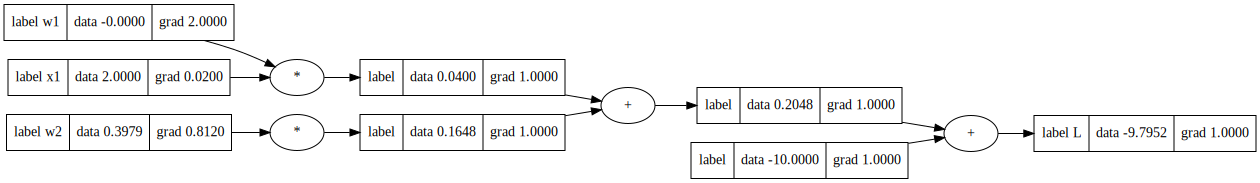

In [119]:
draw_dot(L)

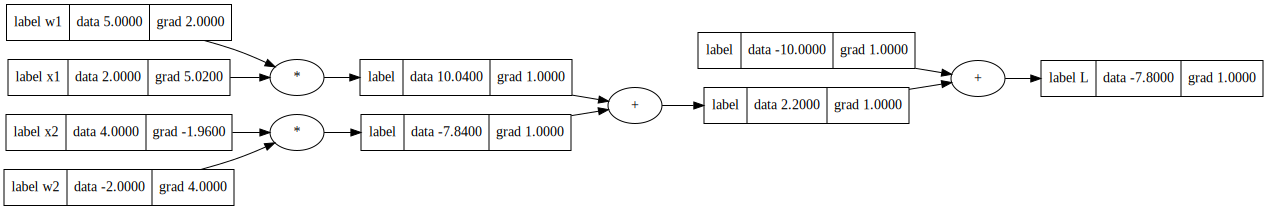

In [113]:
draw_dot(L)

In [58]:
L.backward()

# Playground

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def y(a,b):
    return a+b

In [ ]:
a = np.linspace(0,10,10)
plt.plot(a,y(a,10))

In [16]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(L)

In [17]:
topo

[(:  data = 2),
 (:  data = 4),
 (A:  data = 2),
 (:  data = 6),
 (e:  data = 12),
 (:  data = 14)]